In [1]:
import subprocess
from dataclasses import dataclass, field
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from adis_tools.parsers import parse_pw
from ase.build import bulk
from ase.io import write
from jobflow import job, Response, Flow, run_locally, Maker
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

In [2]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}
# pseudo_dir = str(Path.cwd() / 'pseudo')

In [3]:
parameters_relax = {
    'CONTROL': {
        'calculation': 'vc-relax',
        # 'pseudo_dir': pseudo_dir,
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'degauss': 0.02,
    }
}

In [4]:
parameters_static = {
    'CONTROL': {
        'calculation': 'scf',
        # 'pseudo_dir': pseudo_dir,
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'degauss': 0.02,
    }
}

In [5]:
@dataclass
class QERelaxMaker(Maker):
    name: str = "QE Relax Maker"

    pseudopotentials: dict = field(default_factory=lambda: pseudopotentials)
    parameters: dict = field(default_factory=lambda: parameters_relax)

    # can have an output schema
    @job
    def make(self, structure: Structure):
        # typically we start by copying outputs from previous uns

        # write inputs
        write(
            'relax.pwi',
            AseAtomsAdaptor.get_atoms(structure),
            kpts=(3, 3, 3),
            input_data=self.parameters,
            pseudopotentials=self.pseudopotentials,
        )
        subprocess.check_output("OMP_NUM_THREADS=1 mpirun -np 1 pw.x -in relax.pwi > relax.pwo", shell=True,
                                universal_newlines=True)
        relaxed_structure = parse_pw('pwscf.xml')['ase_structure']

        return {"structure": AseAtomsAdaptor.get_structure(relaxed_structure)}

In [6]:
@dataclass
class QEStaticMaker(Maker):
    name: str = "QE Static Maker"

    # this is not really needed for usage but makes it more convenient
    pseudopotentials: dict = field(default_factory=lambda: pseudopotentials)
    parameters: dict = field(default_factory=lambda: parameters_static)

    # can have an output schema
    @job
    def make(self, structure: Structure):
        # typically we start by copying outputs from previous uns

        # write inputs
        write(
            'strain.pwi',
            AseAtomsAdaptor.get_atoms(structure),
            kpts=(3, 3, 3),
            input_data=self.parameters,
            pseudopotentials=self.pseudopotentials,
        )
        subprocess.check_output("OMP_NUM_THREADS=1 mpirun -np 1 pw.x -in strain.pwi > strain.pwo", shell=True,
                                universal_newlines=True)
        results = parse_pw('pwscf.xml')
        return {"energy": results['energy'], "volume": results['ase_structure'].get_volume()}


In [7]:
@job
def get_ev_curve(relaxed_structure, strain_min=0.9, strain_max=1.1, num_volumes=5):
    # structure to atoms
    relaxed_structure = AseAtomsAdaptor().get_atoms(relaxed_structure)
    jobs = []
    volumes = []
    energies = []
    for strain in np.linspace(strain_min, strain_max, num_volumes):
        structure_strain = relaxed_structure.copy()
        structure_strain.set_cell(structure_strain.cell * strain ** (1 / 3), scale_atoms=True)

        new_job = QEStaticMaker().make(AseAtomsAdaptor.get_structure(structure_strain))
        jobs.append(new_job)
        volumes.append(new_job.output["volume"])
        energies.append(new_job.output["energy"])
    return Response(replace=Flow(jobs, output={"energies": energies, "volumes": volumes}))


In [8]:
@job
def get_plot(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")

2024-01-29 09:42:23,086 INFO Started executing jobs locally
2024-01-29 09:42:23,882 INFO Starting job - QE Relax Maker (3f76e4d6-4a67-4f0d-b9e0-4948fd9c4b9a)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:42:44,075 INFO Finished job - QE Relax Maker (3f76e4d6-4a67-4f0d-b9e0-4948fd9c4b9a)
2024-01-29 09:42:44,077 INFO Starting job - get_ev_curve (6e53287f-ff1a-451f-9b49-f1e2a46e9346)
2024-01-29 09:42:44,082 INFO Finished job - get_ev_curve (6e53287f-ff1a-451f-9b49-f1e2a46e9346)
2024-01-29 09:42:44,104 INFO Starting job - QE Static Maker (0304e9c8-f4dc-4373-b87b-fbbab5d9124f)
2024-01-29 09:42:47,111 INFO Finished job - QE Static Maker (0304e9c8-f4dc-4373-b87b-fbbab5d9124f)
2024-01-29 09:42:47,113 INFO Starting job - QE Static Maker (a763bf10-0e98-4466-91cb-25a7f18b259e)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:42:50,162 INFO Finished job - QE Static Maker (a763bf10-0e98-4466-91cb-25a7f18b259e)
2024-01-29 09:42:50,177 INFO Starting job - QE Static Maker (b053b14e-c54d-440d-9ccd-fb62d27cef20)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:42:53,356 INFO Finished job - QE Static Maker (b053b14e-c54d-440d-9ccd-fb62d27cef20)
2024-01-29 09:42:53,387 INFO Starting job - QE Static Maker (ee34c28a-bdc2-49f0-984f-6e7fdeaa3f0a)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:42:56,879 INFO Finished job - QE Static Maker (ee34c28a-bdc2-49f0-984f-6e7fdeaa3f0a)
2024-01-29 09:42:56,881 INFO Starting job - QE Static Maker (0413f524-f2a1-49f3-aeaf-189b90ad3a9f)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:43:00,461 INFO Finished job - QE Static Maker (0413f524-f2a1-49f3-aeaf-189b90ad3a9f)
2024-01-29 09:43:00,463 INFO Starting job - store_inputs (6e53287f-ff1a-451f-9b49-f1e2a46e9346, 2)
2024-01-29 09:43:00,464 INFO Finished job - store_inputs (6e53287f-ff1a-451f-9b49-f1e2a46e9346, 2)
2024-01-29 09:43:00,466 INFO Starting job - get_plot (8eaa363e-9846-4ae3-9383-0afe2fa8456c)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2024-01-29 09:43:00,500 INFO Finished job - get_plot (8eaa363e-9846-4ae3-9383-0afe2fa8456c)
2024-01-29 09:43:00,500 INFO Finished executing jobs locally


{'3f76e4d6-4a67-4f0d-b9e0-4948fd9c4b9a': {1: Response(output={'structure': Structure Summary
  Lattice
      abc : 4.045218941850908 4.045218941850908 4.045218941850907
   angles : 90.0 90.0 90.0
   volume : 66.19513870282248
        A : 4.045218941850908 0.0 0.0
        B : 0.0 4.045218941850908 0.0
        C : 0.0 0.0 4.045218941850907
      pbc : True True True
  PeriodicSite: Al (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
  PeriodicSite: Al (0.0, 2.023, 2.023) [0.0, 0.5, 0.5]
  PeriodicSite: Al (2.023, 0.0, 2.023) [0.5, 0.0, 0.5]
  PeriodicSite: Al (2.023, 2.023, 0.0) [0.5, 0.5, 0.0]}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False)},
 '6e53287f-ff1a-451f-9b49-f1e2a46e9346': {1: Response(output=None, detour=None, addition=None, replace=Flow(name='Flow', uuid='c00fd299-ebdb-4e57-8af8-5b3060b341fb')
  1. Job(name='QE Static Maker', uuid='0304e9c8-f4dc-4373-b87b-fbbab5d9124f')
  2. Job(name='QE Static Maker', uuid='a763bf10-0e98-4466-91cb-25a7f

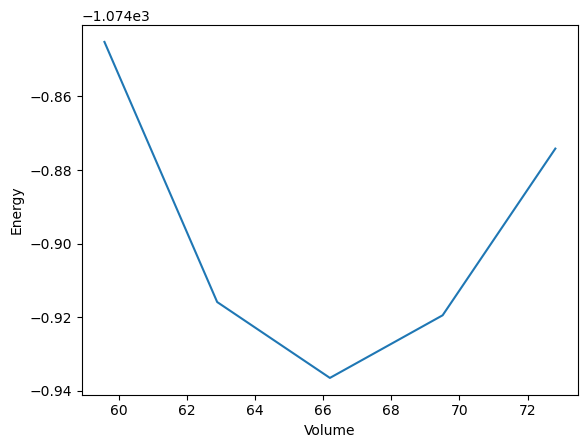

In [9]:
structure = bulk('Al', a=4.15, cubic=True)
relax = QERelaxMaker().make(AseAtomsAdaptor.get_structure(structure))
ev_curve = get_ev_curve(relax.output["structure"])
plot = get_plot(volume_lst=ev_curve.output["volumes"], energy_lst=ev_curve.output["energies"])
jobs = [relax, ev_curve, plot]
run_locally(Flow(jobs), create_folders=True)